In [1]:
import pyvisa
import datetime
import json
import time
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Connect to keithleys
rm = pyvisa.ResourceManager()
print(rm.list_resources())

vsource = rm.open_resource('GPIB1::9::INSTR') #Change the number to the source you're using

print("Using " + vsource.query('*IDN?'))


('TCPIP0::18.25.29.125::inst0::INSTR', 'TCPIP0::K-CX3300-ERIAL.local::hislip0::INSTR', 'TCPIP0::K-CX3300-ERIAL.local::inst0::INSTR', 'ASRL1::INSTR', 'ASRL4::INSTR', 'GPIB1::9::INSTR')
Using Keithley Instruments Inc., Model 2657A, 1409200, 1.1.8



In [5]:
vsource.write('smua.reset()')


14

In [26]:
# experiment_name = 'test'
data_dir = 'C://Users//kashkin//Desktop//keithley data//'

current_limit = 100.0e-3
voltage_limit = 2200

notes = 'testing jorge stuff'
iterates = 3
data_points = 41
upper_voltage = 20

measurement_count = 1
filter_measurement_count = 5
experiment_name = 'vsweep up to {voltage} V'.format(voltage=upper_voltage)
nplc = 1 # nplc/60 is the period of the measurement
input_voltages = list(np.linspace(0, upper_voltage, num=data_points))


In [27]:
# Configure as voltage source
vsource.write(' \
    smua.source.func = smua.OUTPUT_DCVOLTS \n\
    display.smua.measure.func = display.MEASURE_DCAMPS \n\
    smua.measure.autozero = smua.AUTOZERO_AUTO \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limiti = {i_lim} \n\
    smua.measure.adc = smua.ADC_INTEGRATE \n\
    smua.measure.nplc = {nplc} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.measure.count = {m_count} \n\
    smua.measure.filter.count = {f_count} \n\
    smua.measure.filter.enable = smua.FILTER_ON \n\
    smua.measure.filter.type = smua.FILTER_REPEAT_AVG \
    '.format(i_lim = current_limit, v_lim = voltage_limit, m_count = measurement_count, nplc=nplc, f_count = filter_measurement_count))

575

In [28]:
aggregate_data = {'notes':notes}
for i in range(iterates):
    aggregate_data['iterate_{i}'.format(i=i)] = {'input_voltages':[],'measured_voltages':[],'measured_currents':[],'times':[]}

In [29]:
# Conduct iteration of voltages applied to emitter with extractor set as ground
start_time = float(datetime.datetime.now().timestamp())
for i in range(iterates):
    for voltage in input_voltages:
        vsource.write('smua.source.levelv = %s'%voltage)

        vsource.write('ireading, vreading = smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)')

        measured_current = float(vsource.query("print(ireading)")[:-1])
        measured_voltage = float(vsource.query("print(vreading)")[:-1])

        aggregate_data['iterate_{i}'.format(i=i)]['input_voltages'].append(voltage)
        aggregate_data['iterate_{i}'.format(i=i)]['measured_voltages'].append(measured_voltage)
        aggregate_data['iterate_{i}'.format(i=i)]['measured_currents'].append(measured_current)
        aggregate_data['iterate_{i}'.format(i=i)]['times'].append(float(datetime.datetime.now().timestamp()) - start_time)

vsource.write('smua.source.levelv = 0')


24

0.0872647523880005
11.459380478772857


(array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 29.]),
 array([0.079916  , 0.0809516 , 0.08198719, 0.08302279, 0.08405838,
        0.08509398, 0.08612957, 0.08716516, 0.08820076, 0.08923635,
        0.09027195]),
 <BarContainer object of 10 artists>)

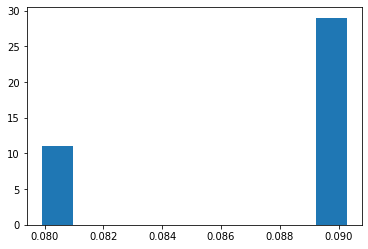

In [30]:
dts = []
for i in range(len(aggregate_data['iterate_1']['times']) - 1):
    dts.append(aggregate_data['iterate_1']['times'][i+1] - aggregate_data['iterate_1']['times'][i])
print(np.average(dts))
print(1/np.average(dts))
plt.hist(dts)

In [31]:
plt.show()

In [32]:
filename = data_dir + experiment_name + '_ %s'%datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S') + '.json'

with open(filename, 'w') as file:
    json.dump(aggregate_data, file)

print('saved to %s' %{filename})

saved to {'C://Users//kashkin//Desktop//keithley data//vsweep up to 20 V_ 2022_11_23-18_08_23.json'}


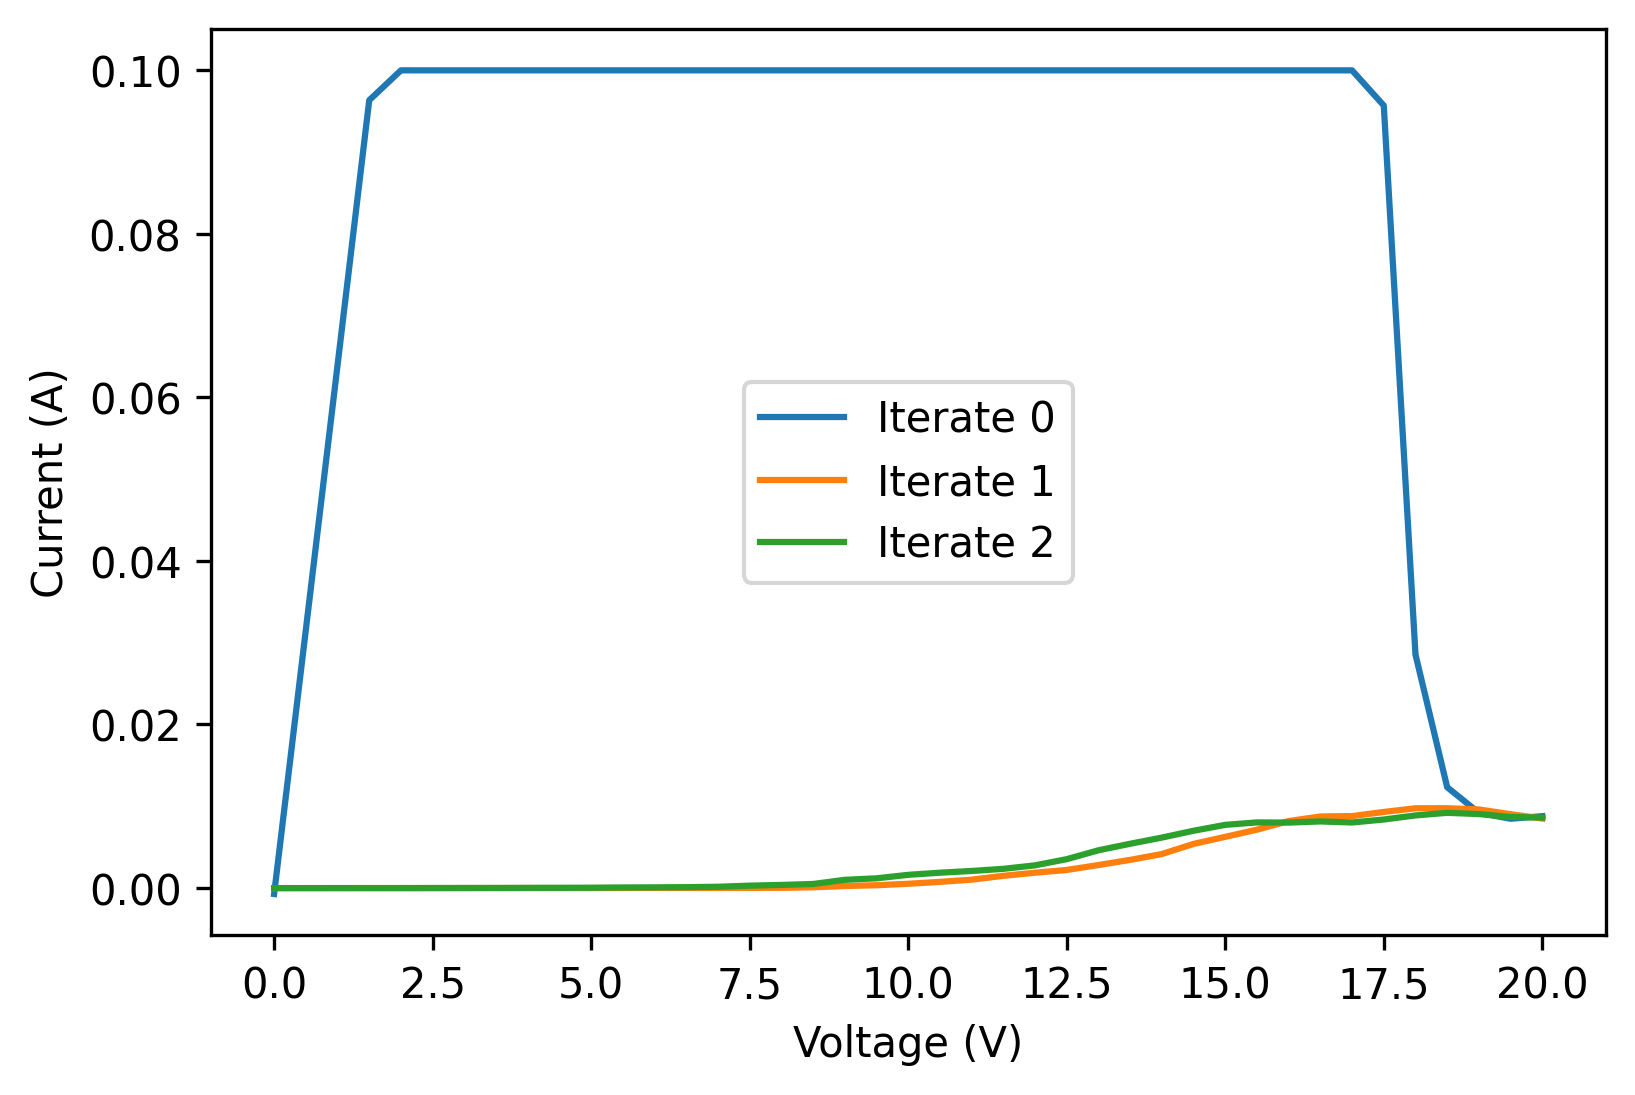

In [33]:
plt.figure(dpi=300)
for i in range(0, iterates):
    input_voltages = aggregate_data['iterate_{i}'.format(i=i)]['input_voltages']
    currents = aggregate_data['iterate_{i}'.format(i=i)]['measured_currents']

    plt.plot(input_voltages, currents,label='Iterate %s'%i)

plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()

In [35]:
#Turn off output and drain capacitors
print("\nSetting source voltage to 0 V")
vsource.write("smua.source.levelv = 0")

print("Turning off output")
vsource.write("smua.source.output = 0")

print("Closing Keithley connection")
vsource.close()



Setting source voltage to 0 V


InvalidSession: Invalid session handle. The resource might be closed.